http://preview.d2l.ai/d2l-en/master/chapter_generative-adversarial-networks/gan.html

In [1]:
%matplotlib inline
from d2l import tensorflow as d2l
import tensorflow as tf

https://www.tensorflow.org/api_docs/python/tf/random/normal

https://www.tensorflow.org/api_docs/python/tf/norm

In [2]:
X = d2l.normal([1000, 2], 0.0, 1, tf.float32)

In [3]:
A = d2l.tensor([[1, 2], [-0.1, 0.5]], tf.float32)
b = d2l.tensor([1, 2], tf.float32)
data = d2l.matmul(X, A) + b

The covariance matrix is
[[1.01 1.95]
 [1.95 4.25]]


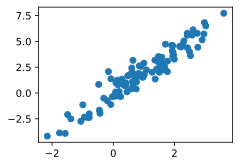

In [4]:
d2l.set_figsize()
d2l.plt.scatter(d2l.numpy(data[:100, 0]), d2l.numpy(data[:100, 1]));
print(f'The covariance matrix is\n{d2l.matmul(tf.transpose(A), A)}')

In [5]:
batch_size = 8
data_iter = d2l.load_array((data,), batch_size)

In [6]:
net_G = tf.keras.Sequential()
net_G.add(tf.keras.layers.Dense(2))

tf.keras.activations.tanh(a)
https://www.tensorflow.org/api_docs/python/tf/keras/activations/tanh


In [7]:
net_D = tf.keras.Sequential()
net_D.add(tf.keras.layers.Dense(5, activation='tanh'))
net_D.add(tf.keras.layers.Dense(3, activation='tanh'))
net_D.add(tf.keras.layers.Dense(1, activation='sigmoid'))

with tf.GradientTape() as t:
http://preview.d2l.ai/d2l-en/master/chapter_preliminaries/autograd.html


t.gradient(y, x) 
t.gradient(loss_D, trainer_D) 

.apply_gradients(zip(grads, self.generator.trainable_weights))
https://keras.io/examples/generative/dcgan_overriding_train_step/

In [8]:
#@save
def update_D(X, Z, net_D, net_G, loss, trainer_D):
    """Update discriminator."""
    batch_size = tf.shape(X)[0]
    ones = tf.ones((batch_size, ), tf.float32)
    zeros = tf.zeros((batch_size, ), tf.float32)
    with tf.GradientTape() as t:
        real_Y = net_D(tf.convert_to_tensor(X))
        fake_X = net_G(tf.convert_to_tensor(Z))
        # Do not need to compute gradient for `net_G`, detach it from
        # computing gradients.
        fake_Y = net_D(tf.stop_gradient(fake_X))
        loss_D = (loss(real_Y, ones)
                + loss(fake_Y, zeros)) / 2
    grads = t.gradient(loss_D, net_D.trainable_variables)
    trainer_D.apply_gradients(zip(grads, net_D.trainable_weights))
    return float(loss_D)

https://www.tensorflow.org/api_docs/python/tf/reshape

In [9]:
#@save
def update_G(Z, net_D, net_G, loss, trainer_G):
    """Update generator."""
    batch_size = tf.shape(Z)[0]
    ones = tf.ones((batch_size, ), tf.float32)
    with tf.GradientTape() as t:
        # We could reuse `fake_X` from `update_D` to save computation
        fake_X = net_G(tf.convert_to_tensor(Z))
        # Recomputing `fake_Y` is needed since `net_D` is changed
        fake_Y = net_D(fake_X)
        loss_G = loss(fake_Y, ones)
    grads = t.gradient(loss_G, net_G.trainable_variables) 
    trainer_G.apply_gradients(zip(grads, net_G.trainable_weights))
    return float(loss_G)

https://www.google.com/search?q=numpy()+tensorflow&rlz=1C1GCEA_enJP909HK909&oq=numpy()+tensorflow&aqs=chrome..69i57j0l7.2792j0j1&sourceid=chrome&ie=UTF-8

https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam
tf.keras.optimizers.Adam(learning_rate=0.1)
m.compile
m = tf.keras.models.Sequential([tf.keras.layers.Dense(10)])
m.compile(opt, loss='mse')

https://stackoverflow.com/questions/55683729/bcewithlogitsloss-in-keras
https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy


def weight_variable(shape, w=0.1):
  initial = tf.truncated_normal(shape, stddev=w)
  return tf.Variable(initial)
  https://stackoverflow.com/questions/43489697/tensorflow-weight-initialization

  The values generated are similar to values from a tf.keras.initializers.RandomNormal initializer except that values more than two standard deviations from the mean are discarded and re-drawn.
  https://keras.io/api/layers/initializers/

tf.Variable(initial_value=w_init(
            shape=(input_dim, unit), dtype=tf.float32), trainable=True)
            https://zhuanlan.zhihu.com/p/59481536

https://keras.io/api/layers/initializers/

numpy.array
https://stackoverflow.com/questions/41198144/attributeerror-tuple-object-has-no-attribute-shape

https://github.com/tensorflow/tensorflow/issues/29972

tf.stop_gradient(y)
http://preview.d2l.ai/d2l-en/master/chapter_preliminaries/autograd.html?highlight=detach

 from_logits=True 9.2.4 TensorFlow 2.0 神经网络实践

In [10]:
def train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G, latent_dim, data):
    loss = tf.keras.losses.BinaryCrossentropy(reduction=
                tf.keras.losses.Reduction.SUM)
    tf.keras.initializers.RandomNormal(net_D, stddev=0.02)
    tf.keras.initializers.RandomNormal(net_G, stddev=0.02)
    trainer_D = tf.keras.optimizers.Adam(learning_rate=lr_D)
    trainer_G = tf.keras.optimizers.Adam(learning_rate=lr_G)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)
    for epoch in range(num_epochs):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for X in data_iter:
            batch_size = tf.shape(X)[0]
            Z = d2l.normal([batch_size, latent_dim], 0, 1, tf.float32)
            metric.add(update_D(X, Z, net_D, net_G, loss, trainer_D),
                       update_G(Z, net_D, net_G, loss, trainer_G),
                       batch_size)
        # Visualize generated examples
        Z = d2l.normal([100, latent_dim], 0, 1, tf.float32)
        fake_X = net_G(Z).numpy()
        animator.axes[1].cla()
        animator.axes[1].scatter(data[:, 0], data[:, 1])
        animator.axes[1].scatter(fake_X[:, 0], fake_X[:, 1])
        animator.axes[1].legend(['real', 'generated'])
        # Show the losses
        loss_D, loss_G = metric[0]/metric[2], metric[1]/metric[2]
        animator.add(epoch + 1, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec')

loss_D 7.713, loss_G 0.000, 45.6 examples/sec


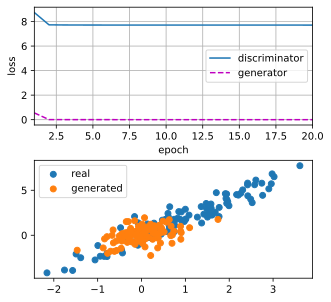

In [11]:
lr_D, lr_G, latent_dim, num_epochs = 0.05, 0.005, 2, 20
train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G,
      latent_dim, d2l.numpy(data[:100]))

https://www.tensorflow.org/api_docs/python/tf/ones